# Canny edge detector

## to do:

1. Noise reduction (Gauss)
2. Gradient
3. Non-max Suppression
4. Double Treshold
5. Edge tracking: Hysteresis

In [111]:
from PIL import Image, ImageFilter, ImageDraw
import numpy as np

def toGris(image, std=601, returnArr=False):
    
    m=np.array(image)
    
    rec601 = (0.29894, 0.58704, 0.11402)
    rec709 = (0.2126, 0.7152, 0.0722)
    
    recStandard = rec601 if (std == 601) else rec709
    
    matrixCols = m.shape[0]
    matrixRows = m.shape[1]
    
    np_im = np.zeros((matrixCols,matrixRows))
    for i in range(matrixCols):
        for j in range(matrixRows):
            #convert to GreyScale (only RGB suppoted at the momment)
            np_im[i,j] = round(m[i,j,0] * recStandard[0])
            np_im[i,j] += round(m[i,j,1] * recStandard[1])
            np_im[i,j] += round(m[i,j,2] * recStandard[2])
            
            
    print(np_im.shape)
    print("min val: %s max val: %s" % (np_im.min(),np_im.max()))
    print("Using standard: rec%s" % (std))

    if (returnArr):
        return np_im.astype(np.uint8) 
    else:
        return Image.fromarray(np_im.astype(np.uint8))
    
#Function to "flip" de Kernell for convolution
def flipKernel(k):
    #Get array shape
    filas = k.shape[0]
    columnas = k.shape[1]
    
    #Create resulting array
    r = np.zeros((filas, columnas))
    #print(r)
    
    #support vars
    i = j = 0
    n = m = 0
    
    for x in k:
        for val in x:
            #print(k[i,j])
            n = filas-1-i
            m = columnas-1-j
            #print("Val: %s fila: %s Col: %s" % (val, n, m))
            r[n,m] = val
            
            if (j < columnas-1):
                j = j+1
            else:
                i += 1
                j = 0
    return r

def frameWithZeros(image, kernel):
    kR = kernel.shape[0]//2
    kC = kernel.shape[1]//2
    
    #new shape to ensure resulting image is the expected size
    sR = np.zeros((image.shape[0],kR))
    nH = np.hstack((sR,image,sR))
    sC = np.zeros((kC,nH.shape[1]))
    nH = np.vstack((sC,nH,sC))
    
    return nH


def applyKernelToSegment(kernel, segment, pos):
    x = pos[0]
    y = pos[1]
    kR = kernel.shape[0]//2
    kC = kernel.shape[1]//2
    
    r = 0
    
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            r = r + (kernel[i,j] * segment[(x + (i-kR),y + (j-kC))])
       
    return r

def normaliza(np_image, treshold=90):
    scaleMax = 255 #assuming 0 - 255 resulting scale
    minval = np_image.min()
    maxval = np_image.max()
    
    r = np.zeros((np_image.shape))
    
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            tm = np.floor((np_image[i,j] + maxval) * scaleMax / (maxval - minval))
            r[i,j] = tm if (tm > treshold) else 0
            
    return r.astype(np.uint8)

def applyKernel(image, kernel, returnArr=False, treshold =140):
    np_image = np.array(image)
    kR = kernel.shape[0]//2
    kC = kernel.shape[1]//2
    r = np.zeros((np_image.shape))
    
    nImage = frameWithZeros(np_image, kernel)
    
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            #print(applyKernel(w, nH, (i+kR,j+kC)))
            r[i,j] = applyKernelToSegment(flipKernel(kernel), nImage, (i+kR,j+kC))
            
    if (returnArr):
        return normaliza(r, treshold)  
    else:
        return Image.fromarray(normaliza(r, treshold))


### Load image

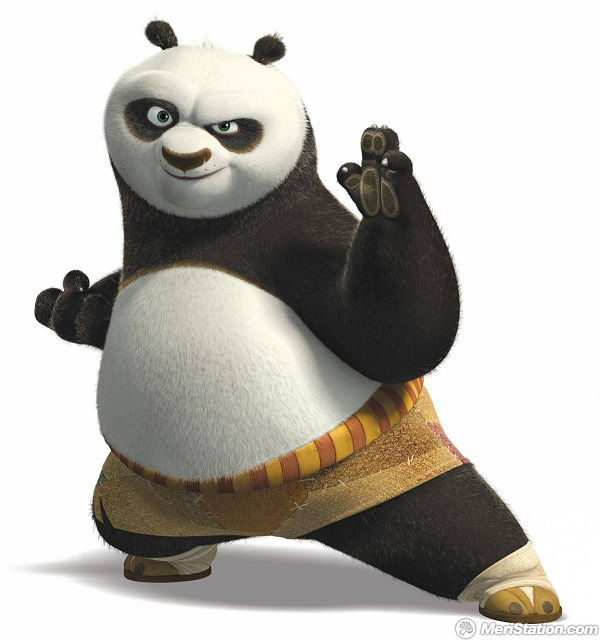

In [56]:
img = pil.Image.open("panda.jpg")
img

## Convert to gray scale

In [64]:
gray_panda = toGris(img)

(640, 600)
min val: 2.0 max val: 255.0
Using standard: rec601


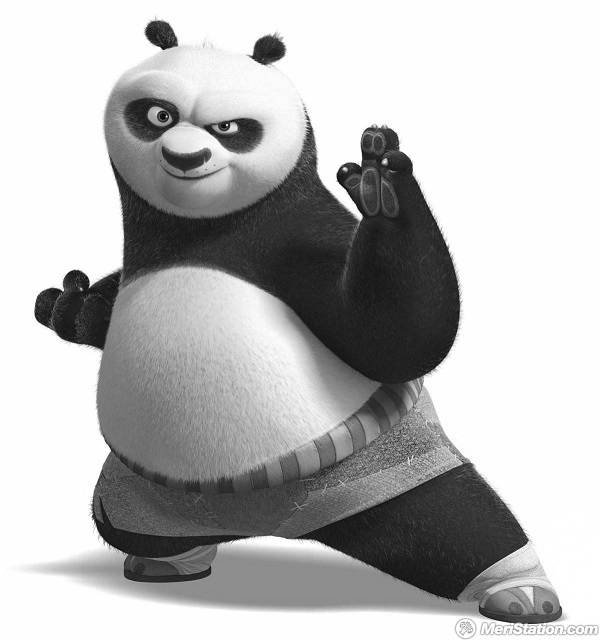

In [65]:
gray_panda

## Apply Gauss filter

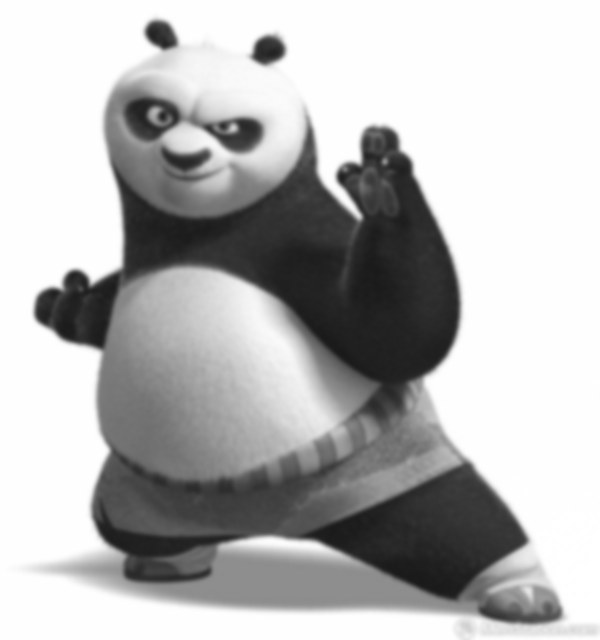

In [66]:
gauss_panda = gray_panda.filter(ImageFilter.GaussianBlur(radius = 2)) 
gauss_panda

## Calculcate Gradient

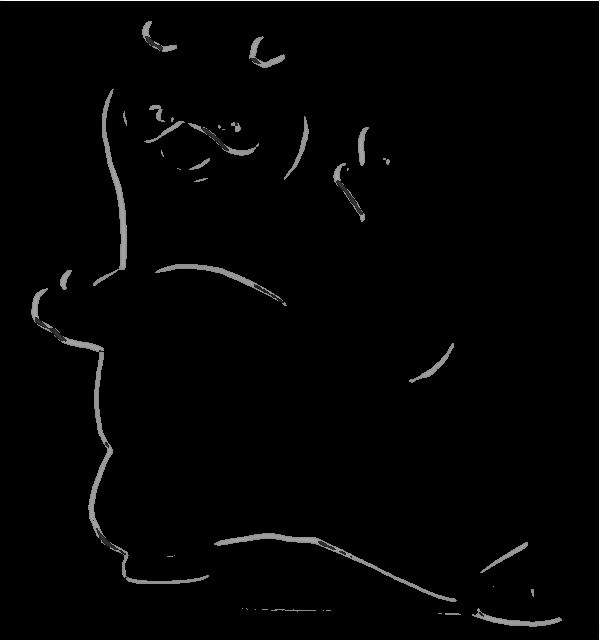

In [172]:
sobelx = np.array([[-1,0,1],
                  [-2,0,2],
                  [-1,0,1]])

sobely = np.array([[1,2,1],
                   [0,0,0],
                   [-1,-2,-1]])

sx = applyKernel(gauss_panda, sobelx)
sy = applyKernel(gauss_panda, sobely)
sobel_panda = Image.fromarray(np.array(sx)+np.array(sy))
sobel_panda

In [80]:
Ix = applyKernel(gauss_panda, sobelx,1)
Iy = applyKernel(gauss_panda, sobely,1)

In [89]:
G = np.sqrt(np.square(Ix)+np.square(Iy))
G = abs(G)
G

array([[11.49,  2.  ,  2.  , ...,  2.  ,  2.  , 14.04],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  3.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  2.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  8.06]], dtype=float16)

In [102]:
#Gradiente magnitude
G = np.hypot(Ix,Iy)
G

array([[222. , 254. , 254. , ..., 254. , 254. , 314.8],
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 255. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 255. ],
       ...,
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 253. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 254. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 223. ]], dtype=float16)

In [184]:
G = G / G.max() * 255
G

array([[179.8, 205.9, 205.9, ..., 205.9, 205.9, 255. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 206.6],
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 206.6],
       ...,
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 205. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 205.9],
       [  0. ,   0. ,   0. , ...,   0. ,   0. , 180.6]], dtype=float16)

In [110]:
#slope theta
theta = np.arctan2(Iy,Ix)
theta

array([[1.57 , 1.57 , 1.57 , ..., 1.57 , 1.57 , 0.783],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]], dtype=float16)

In [107]:
theta.max()

1.57

In [154]:
deg = np.rad2deg(theta)
deg

array([[90.  , 90.  , 90.  , ..., 90.  , 90.  , 44.88],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]], dtype=float16)

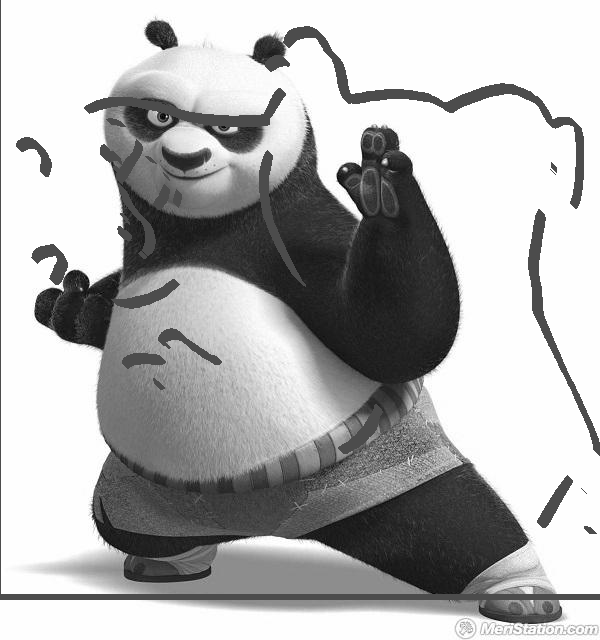

In [190]:
gradient_panda = pil.Image.open("pandaGris.jpg")
np_panda = np.array(gradient_panda)


test = ImageDraw.Draw(gradient_panda)
#test.line([(500, 500), (1, 1)] , fill="white", width=2)
c,r = np_panda.shape

for i in range(c):
    for j in range(r):
        if(G[i, j] > 100):
            test.line([(i, j), (i-5, j-5)] , fill="red", width=1)
#Image.fromarray(play)
gradient_panda

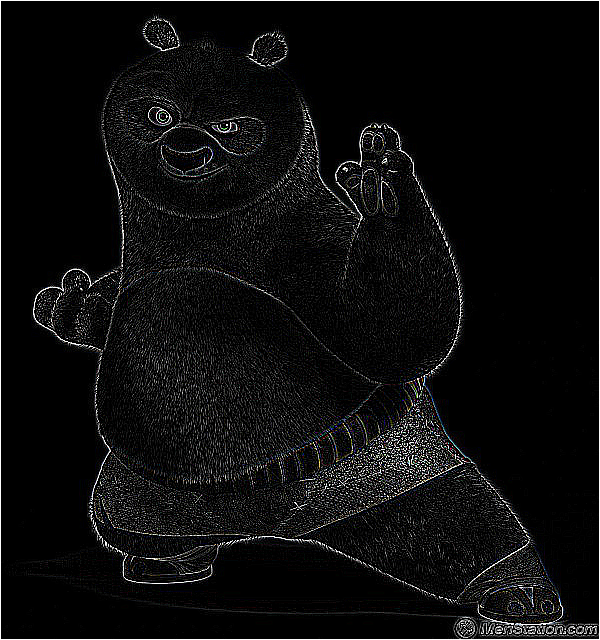

In [48]:
img.filter(ImageFilter.FIND_EDGES)